## Neural Network to predict the house prices in California

Predicts the house price based on features such as median income, house age, average rooms, average bed rooms, etc

### 1. Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

### 2. Load the dataset (California house prices)

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['PRICE'] = housing.target # We set the target attribute to the price 

data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
data.head() # Displays the first few rows of our dataset

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Split the data into training and testing sets

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop('PRICE', axis=1) # We use all the variables EXCEPT the price as the input parameters
y = data['PRICE'] # Based on the input parameters (X) we predict the price (Y). The Y is the dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16512, 8), (4128, 8), (16512,), (4128,))

Create the training tensors

In [11]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [16]:
train_dataset.tensors

(tensor([[   3.2596,   33.0000,    5.0177,  ...,    3.6918,   32.7100,
          -117.0300],
         [   3.8125,   49.0000,    4.4735,  ...,    1.7381,   33.7700,
          -118.1600],
         [   4.1563,    4.0000,    5.6458,  ...,    2.7232,   34.6600,
          -120.4800],
         ...,
         [   2.9344,   36.0000,    3.9867,  ...,    3.3321,   34.0300,
          -118.3800],
         [   5.7192,   15.0000,    6.3953,  ...,    3.1789,   37.5800,
          -121.9600],
         [   2.5755,   52.0000,    3.4026,  ...,    2.1087,   37.7700,
          -122.4200]]),
 tensor([[1.0300],
         [3.8210],
         [1.7260],
         ...,
         [2.2210],
         [2.8350],
         [3.2500]]))

In [17]:
train_loader.batch_size

32

**Batch size** refers to the number of samples (data points) that the model processes at once before updating its internal parameters during training.

Here, we have a large number of training examples (e.g., house prices and their features). Instead of making the model look at all the examples at once (which could be very slow and require a lot of memory), you break the data into smaller groups or batches.

Batches make it faster and requires less memory than processing all of them at once. It also ensures smoother training

### Create the neural network using PyTorch

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) # the input layer
        self.fc2 = nn.Linear(64, 32) # one hidden layer
        self.fc3 = nn.Linear(32, 1) # the output layer

    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    """
    The Rectified Linear Unit (ReLU) is the most commonly used activation function in deep learning models. 
    The function returns 0 if it receives any negative input, but for any positive value x it returns that value back.
    """

In [19]:
# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = HousePriceModel(input_dim)

### Train the model

In [21]:
from torch import optim


# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.8628
Epoch [20/100], Loss: 0.3181
Epoch [30/100], Loss: 0.5784
Epoch [40/100], Loss: 0.4154
Epoch [50/100], Loss: 0.5656
Epoch [60/100], Loss: 0.5625
Epoch [70/100], Loss: 0.8667
Epoch [80/100], Loss: 0.5717
Epoch [90/100], Loss: 0.5601
Epoch [100/100], Loss: 0.6349


### Evaluate the model

In [22]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor).item()

# Calculate RMSE
rmse = torch.sqrt(torch.tensor(test_loss))
print(f'Test Loss (MSE): {test_loss:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')


Test Loss (MSE): 0.5288
Root Mean Squared Error: 0.7272


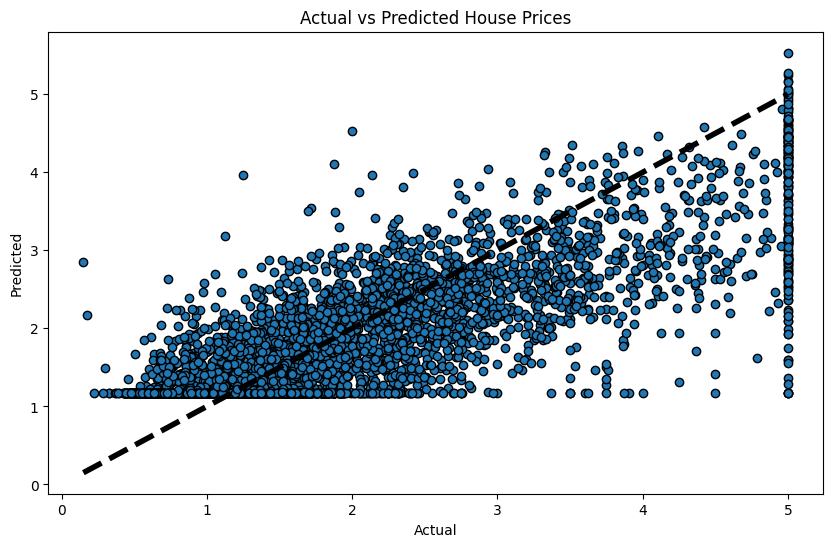

In [23]:
# Convert predictions to numpy
y_pred_numpy = y_pred.numpy()
y_test_numpy = y_test_tensor.numpy()

# Plot predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_numpy, y_pred_numpy, edgecolors=(0, 0, 0))
plt.plot([y_test_numpy.min(), y_test_numpy.max()], [y_test_numpy.min(), y_test_numpy.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted House Prices')
plt.show()